In [41]:
# Cell 1: Imports and basic config
import os
import random
import shutil
from datetime import datetime
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.io import read_video
from torchvision.transforms import ToPILImage
from tqdm import tqdm
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device')

# Fix random seeds for reproducibility
random.seed(17)
torch.manual_seed(17)

# ImageNet stats
IMG_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]


device


In [42]:
!nvidia-smi

Sun Aug  3 19:56:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8             17W /   65W |     336MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [51]:
# Cell: install and import
# !pip install opencv-python pillow

import cv2
from PIL import Image

class VideoFrameDatasetCV2(Dataset):
    def __init__(self, root_dir, folders, transform=None):
        self.samples = []
        for label, folder in enumerate(folders):
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                full = os.path.join(folder_path, fname)
                if os.path.isfile(full):
                    self.samples.append((full, label))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"CV2 can’t open {video_path}")
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if n_frames <= 0:
            cap.release()
            raise RuntimeError(f"No frames in {video_path}")

        # pick a random frame index
        frame_idx = random.randint(0, n_frames - 1)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            raise RuntimeError(f"Failed to read frame {frame_idx} from {video_path}")

        # BGR→RGB and to PIL
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(frame)

        if self.transform:
            img = self.transform(img)

        return img, label


In [59]:
# Cell 3: define transforms and loaders
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

data_root = Path("../subset")
folders = ['DFD_original_sequences', 'DFD_manipulated_sequences']
batch_size = 16
# split indices
# replace VideoFrameDataset with VideoFrameDatasetCV2
dataset_cv2 = VideoFrameDatasetCV2(data_root, folders, transform)

n_train = int(0.8 * len(dataset_cv2))
n_val   = len(dataset_cv2) - n_train
train_ds, val_ds = torch.utils.data.random_split(dataset_cv2, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)


In [60]:
# Cell 4: define your model in OOP style
class EfficientNetVideo(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # load pretrained EfficientNet‐B0
        self.backbone = models.efficientnet_b0(pretrained=True)
        # replace head
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        # our video‐frame classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        # x: [B, 3, H, W]
        feat = self.backbone(x)            # [B, in_features]
        out  = self.classifier(feat)       # [B, num_classes]
        return out


In [61]:
# Cell 5: Trainer to handle training & validation
class Trainer:
    def __init__(self, model, train_loader, val_loader, device, lr=1e-4, ckpt_dir="checkpoints"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.ckpt_dir = ckpt_dir
        os.makedirs(ckpt_dir, exist_ok=True)

        # history
        self.history = {
            "train_loss": [], "train_acc": [],
            "val_loss":   [], "val_acc":   []
        }

    def train_epoch(self):
        self.model.train()
        running_loss, correct, total = 0, 0, 0
        t0 = datetime.now()
        loop = tqdm(self.train_loader, desc="Train", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(self.device), labels.to(self.device)
            preds = self.model(imgs)
            loss = self.criterion(preds, labels)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # stats
            running_loss += loss.item() * imgs.size(0)
            _, preds_idx = preds.max(1)
            correct += (preds_idx == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        epoch_loss = running_loss / total
        epoch_acc  = correct / total
        elapsed = (datetime.now() - t0).total_seconds()
        print(f"→ Train: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}, time={elapsed:.1f}s")
        self.history["train_loss"].append(epoch_loss)
        self.history["train_acc"].append(epoch_acc)

    def validate_epoch(self):
        self.model.eval()
        running_loss, correct, total = 0, 0, 0
        t0 = datetime.now()
        loop = tqdm(self.val_loader, desc="Valid", leave=False)
        with torch.no_grad():
            for imgs, labels in loop:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                preds = self.model(imgs)
                loss = self.criterion(preds, labels)

                running_loss += loss.item() * imgs.size(0)
                _, preds_idx = preds.max(1)
                correct += (preds_idx == labels).sum().item()
                total += labels.size(0)

                loop.set_postfix(loss=loss.item(), acc=100*correct/total)

        epoch_loss = running_loss / total
        epoch_acc  = correct / total
        elapsed = (datetime.now() - t0).total_seconds()
        print(f"→ Valid: loss={epoch_loss:.4f}, acc={epoch_acc:.4f}, time={elapsed:.1f}s")
        self.history["val_loss"].append(epoch_loss)
        self.history["val_acc"].append(epoch_acc)
        return epoch_acc

    def save_checkpoint(self, epoch, best=False):
        fname = f"epoch_{epoch}.pth" if not best else "best_model.pth"
        path = os.path.join(self.ckpt_dir, fname)
        torch.save({
            "epoch": epoch,
            "model_state": self.model.state_dict(),
            "optim_state": self.optimizer.state_dict()
        }, path)
        print(f"[Checkpoint] Saved {fname}")

    def fit(self, epochs=5):
        best_acc = 0.0
        for ep in range(1, epochs+1):
            print(f"\n=== Epoch {ep}/{epochs} ===")
            self.train_epoch()
            val_acc = self.validate_epoch()
            self.save_checkpoint(ep)
            if val_acc > best_acc:
                best_acc = val_acc
                self.save_checkpoint(ep, best=True)
        print(f"\nTraining complete. Best val acc: {best_acc:.4f}")


In [62]:
model   = EfficientNetVideo(num_classes=2)

c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mohit\Desktop\PROJECTS\AI Image Detection\resnet-50\resnet_env_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [63]:
trainer = Trainer(model, train_loader, val_loader, device, lr=1e-4)

In [64]:
trainer.fit(epochs=10)


=== Epoch 1/10 ===


→ Train: loss=0.7278, acc=0.4125, time=36.6s


→ Valid: loss=0.6950, acc=0.5000, time=8.6s
[Checkpoint] Saved epoch_1.pth
[Checkpoint] Saved best_model.pth

=== Epoch 2/10 ===


→ Train: loss=0.6520, acc=0.5938, time=33.3s


→ Valid: loss=0.6635, acc=0.6000, time=8.1s
[Checkpoint] Saved epoch_2.pth
[Checkpoint] Saved best_model.pth

=== Epoch 3/10 ===


→ Train: loss=0.6221, acc=0.6750, time=33.8s


→ Valid: loss=0.6560, acc=0.6000, time=8.7s
[Checkpoint] Saved epoch_3.pth

=== Epoch 4/10 ===


→ Train: loss=0.5902, acc=0.7688, time=34.0s


→ Valid: loss=0.6905, acc=0.5250, time=9.3s
[Checkpoint] Saved epoch_4.pth

=== Epoch 5/10 ===


→ Train: loss=0.5533, acc=0.7562, time=34.9s


→ Valid: loss=0.6689, acc=0.6000, time=8.8s
[Checkpoint] Saved epoch_5.pth

=== Epoch 6/10 ===


→ Train: loss=0.5321, acc=0.7562, time=35.3s


→ Valid: loss=0.7063, acc=0.5250, time=8.7s
[Checkpoint] Saved epoch_6.pth

=== Epoch 7/10 ===


→ Train: loss=0.5131, acc=0.7500, time=34.5s


→ Valid: loss=0.7032, acc=0.6000, time=8.1s
[Checkpoint] Saved epoch_7.pth

=== Epoch 8/10 ===


→ Train: loss=0.4750, acc=0.8063, time=34.3s


→ Valid: loss=0.6925, acc=0.6500, time=8.9s
[Checkpoint] Saved epoch_8.pth
[Checkpoint] Saved best_model.pth

=== Epoch 9/10 ===


→ Train: loss=0.4345, acc=0.8063, time=35.6s


→ Valid: loss=0.6814, acc=0.6750, time=9.4s
[Checkpoint] Saved epoch_9.pth
[Checkpoint] Saved best_model.pth

=== Epoch 10/10 ===


→ Train: loss=0.4383, acc=0.8375, time=35.7s


→ Valid: loss=0.6610, acc=0.6250, time=9.7s
[Checkpoint] Saved epoch_10.pth

Training complete. Best val acc: 0.6750


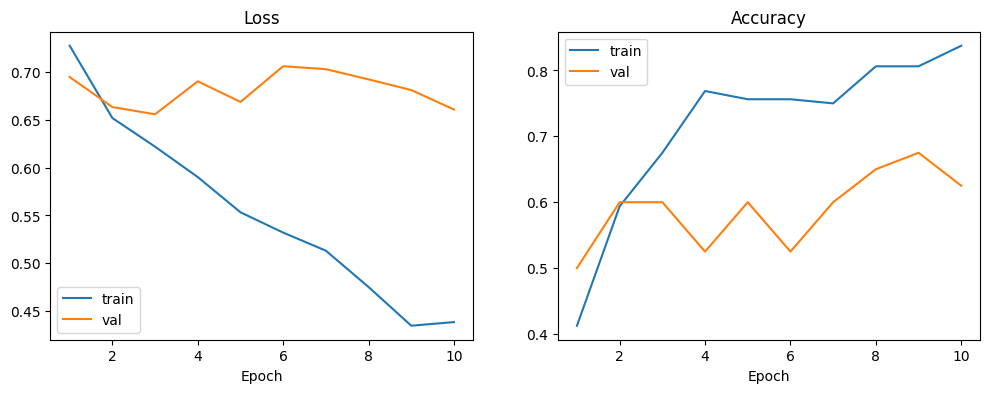

In [65]:
# Cell 7: visualize training curves
h = trainer.history
epochs = range(1, len(h["train_loss"])+1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, h["train_loss"], label="train")
plt.plot(epochs, h["val_loss"],   label="val")
plt.title("Loss")
plt.xlabel("Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, h["train_acc"], label="train")
plt.plot(epochs, h["val_acc"],   label="val")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.legend()

plt.show()


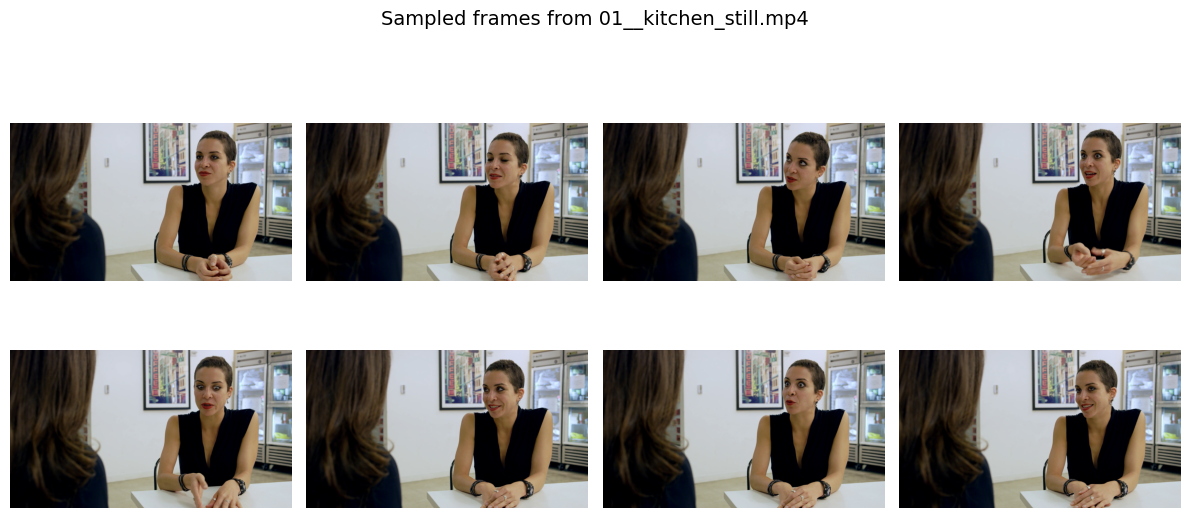


Prediction for 01__kitchen_still.mp4:
  → Label:  REAL
  → Probabilities: Real = 0.9396, Fake = 0.0604


In [67]:
# Cell 8: Inference + Preview using OpenCV

import os
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt

def predict_video_cv2(video_path, model, transform, device, n_samples=8, show_preview=True):
    """
    Read video with OpenCV, sample frames evenly, display a frame grid,
    then run through the model and average the probabilities.
    
    Returns:
      label (0=REAL, 1=FAKE), avg_prob (array([p_real, p_fake]))
    """
    model.eval()
    
    # --- Open video and count frames ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Cannot open video: {video_path}")
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    if total <= 0:
        raise RuntimeError(f"No frames found in: {video_path}")
    
    # --- Select evenly spaced frame indices ---
    idxs = [int(x) for x in torch.linspace(0, total - 1, steps=n_samples).tolist()]
    
    # --- Read & collect frames ---
    frames = []
    cap = cv2.VideoCapture(video_path)
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ok, frm = cap.read()
        if not ok:
            cap.release()
            raise RuntimeError(f"Failed to read frame {i}")
        # BGR → RGB
        frm = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
        frames.append(frm)
    cap.release()
    
    # --- Preview sampled frames in a grid ---
    if show_preview:
        cols = min(4, len(frames))
        rows = (len(frames) + cols - 1) // cols
        plt.figure(figsize=(cols*3, rows*3))
        for idx, frm in enumerate(frames):
            plt.subplot(rows, cols, idx+1)
            plt.imshow(frm)
            plt.axis('off')
        plt.suptitle(f"Sampled frames from {os.path.basename(video_path)}", fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # --- Transform & batch for model ---
    imgs = []
    for frm in frames:
        img = Image.fromarray(frm)
        img_t = transform(img).unsqueeze(0).to(device)
        imgs.append(img_t)
    batch = torch.cat(imgs, dim=0)  # shape: [n_samples, 3, H, W]
    
    # --- Run inference ---
    with torch.no_grad():
        logits = model(batch)             # [n_samples, 2]
        probs = torch.softmax(logits, dim=1)
    avg_prob = probs.mean(dim=0).cpu().numpy()  # [p_real, p_fake]
    label = int(avg_prob.argmax())
    
    return label, avg_prob

# === Example usage ===
video_file = "../subset/DFD_original_sequences/01__kitchen_still.mp4"
pred_label, pred_prob = predict_video_cv2(video_file, model, transform, device)

print(f"\nPrediction for {os.path.basename(video_file)}:")
print(f"  → Label:  {'REAL' if pred_label==0 else 'FAKE'}")
print(f"  → Probabilities: Real = {pred_prob[0]:.4f}, Fake = {pred_prob[1]:.4f}")
